## Plan

We need train model to classify music tracks into genres. We have texts of it and some other musician features. First I want just use text of song to make classifier using nlp, exactly LLM. Then we can use extra features with text feature extractor (trained model from previous step) to make final catboost model.

Plan:

I will use small LLM for feature extractor

1) Zero-shot learning. Make prediction using prompt, for example, "The genre of song {} is {}" and then extract and marginize probabilities of specific genre tokens.  
2) Few-shot learning. Try to improve prompt by adding to it extra examples.
3) Ptune + phead. Use trainable embeddings that will be concatenated with input (lyrics) and linear probing after embedding from last token at last layer.
4) lora. Add LoRA to previous model.
5) Full finetune. Unfreeze all layers of model and use full finetune with ptune and phead.

After feature extractor from previous step will be trained we can use it with other features to create final model.

6) Train catboost with musician features like tempo, key and so on with probabilities of classes that will be gotten from trained feature extractor llm model from previous steps.

In [1]:
# Common imports
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import enum
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tqdm import tqdm

import json
import re

from abc import ABC, abstractmethod

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from transformers import AutoModelForCausalLM, AutoTokenizer

cuda


In [2]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)
logger.info("Logger is working")

2025-05-19 00:22:42,517 - __main__ - INFO - Logger is working


In [3]:
# Config

class DatasetTypes(enum.Enum):
    whole = 0
    small = 1

class Params:
    def __init__(self, exp_name='genre_classification', random_seed=1337, n_epoch=10, batch_size=8, dataset_type=DatasetTypes.whole, 
                 learning_rate=1e-4, weight_decay=1e-5):
        self.random_seed = random_seed
        self.exp_name = exp_name
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.dataset_type = dataset_type
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        
    def __str__(self):
        return ", ".join(f"{k}: {v}" for k, v in vars(self).items())
    
params = Params(dataset_type=DatasetTypes.small)

## Base model

We will got pretty small model because it is just study work. It can be replaced with other larger model.

https://qwenlm.github.io/blog/qwen3/

We will got dense Qwen3-0.6B model.

In [4]:
model_name = "Qwen/Qwen3-0.6B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map=device
)

# # prepare the model input
# prompt = "Give me a short introduction to large language model."
# messages = [
#     {"role": "user", "content": prompt}
# ]
# text = tokenizer.apply_chat_template(
#     messages,
#     tokenize=False,
#     add_generation_prompt=True,
#     enable_thinking=True # Switches between thinking and non-thinking modes. Default is True.
# )
# model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# # conduct text completion
# generated_ids = model.generate(
#     **model_inputs,
#     max_new_tokens=32768
# )
# output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# # parsing thinking content
# try:
#     # rindex finding 151668 (</think>)
#     index = len(output_ids) - output_ids[::-1].index(151668)
# except ValueError:
#     index = 0

# thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
# content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

# print("thinking content:", thinking_content)
# print("content:", content)


## Data proccessing

We already have done data preproccessing in prepare_spotify.ipynb. Here we transform it into torch dataset and dataloader format.

Pay attention that we have multilabel classification problem.

In [5]:
import pandas as pd

df = pd.read_csv(r'data\spotify_480k_with_features.csv')
df = df[:1000] if params.dataset_type == DatasetTypes.small else df  # For experiments use

print(df.head())

2025-05-19 00:22:47,225 - numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-05-19 00:22:47,225 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


  artist                      title  \
0    !!!  Even When the Waters Cold   
1    !!!         One Girl / One Boy   
2    !!!          Pardon My Freedom   
3    !!!                        Ooo   
4    !!!                 Freedom 15   

                                              lyrics length    album_title  \
0  Friends told her she was better off at the bot...  03:47       Thr!!!er   
1  Well I heard it, playing soft From a drunken b...  04:03       Thr!!!er   
2  Oh my god, did I just say that out loud? Shoul...  05:51  Louden Up Now   
3  [Verse 1] Remember when I called you on the te...  03:44          As If   
4  [Verse 1] Calling me like I got something to s...  06:00          As If   

             release     key  tempo loudness time_signature    genre  
0    29th April 2013   D min    105  -6.85db            4/4  hip hop  
1    29th April 2013  A# min    117  -5.75db            4/4  hip hop  
2      8th June 2004   A Maj    121  -6.06db            4/4  hip hop  
3  16th Octo

In [6]:
target = df['genre'].unique()
print(sorted(target))

all_genre_strings = df['genre'].unique()

# Разделяем по запятой и складываем в множество (чтобы получить только уникальные жанры)
all_genres = set()

for genre_string in all_genre_strings:
    genres = genre_string.split(',')
    all_genres.update(genres)

# Преобразуем в отсортированный список (по желанию)
all_genres_list = sorted(all_genres)

print(all_genres_list)
print(f'Genres length: {len(all_genres_list)}')

['alternative rock,indie rock,indie', 'alternative rock,new wave', 'chillout,psychedelic,electronic', 'classical', 'country,classic rock,hard rock', 'country,pop', 'electronic,dance,electropop', 'electronic,rap', 'folk', 'hip hop', 'hip hop,trap,cloud rap', 'hip-hop,hip hop', 'indie rock,britpop', 'jazz', 'k-pop', 'metal,hard rock,heavy metal', 'pop', 'punk,punk rock', 'rap,hip hop', 'rock', 'rock,hardcore,garage rock', 'rock,pop rock', 'rock,pop,comedy', 'rock,synthpop,alternative rock', 'trance,electronic,psychedelic', 'trap']
['alternative rock', 'britpop', 'chillout', 'classic rock', 'classical', 'cloud rap', 'comedy', 'country', 'dance', 'electronic', 'electropop', 'folk', 'garage rock', 'hard rock', 'hardcore', 'heavy metal', 'hip hop', 'hip-hop', 'indie', 'indie rock', 'jazz', 'k-pop', 'metal', 'new wave', 'pop', 'pop rock', 'psychedelic', 'punk', 'punk rock', 'rap', 'rock', 'synthpop', 'trance', 'trap']
Genres length: 34


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

# Разбиваем жанры и убираем пробелы (на всякий случай)
df['genre_list'] = df['genre'].apply(lambda x: [g.strip() for g in x.split(',')])

# Используем MultiLabelBinarizer для преобразования в one-hot
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genre_list'])
genres = mlb.classes_

print(f"Число уникальных жанров: {len(mlb.classes_)}")

Число уникальных жанров: 34


In [8]:
# List of genres for hundredth lyrics: https://www.youtube.com/watch?v=wDQR0-3fFWs&ab_channel=T.I.-Topic
sample_num = 100
print(df['lyrics'][sample_num])
print([genre for genre, flag in zip(genres, y[sample_num]) if flag == 1])

[Intro: Weird Al Yankovic] Hey girl, you know our economy's in the toilet But I'm still gonna treat you right I said you can have whatever you like (if you like) I said you can have whatever you like (if you like) Yeah, yeah [Hook One] Tater tots, Cold Duck on ice And we can clip coupons all night And baby you can have whatever you like (if you like) I said you can have whatever you like (if you like) Yeah, yeah Take you out for dinner, anywhere that you please Like Burger King or Mickey D's And baby you can have whatever you like (if you like) I said you can even have the large fries (large fries) Yeah, yeah [Verse One] Baby you should know I am really quite a sweet guy When I buy you bathroom tissue I always get the two-ply Want it, you can get it, my dear I got my Costco membership card right here Yeah you like Top Ramen, need Top Ramen Got a cupboard full of 'em, I'll keep 'em comin You want it, I got it, go get it, just heat it Dump the flavor packet on it and eat it [Hook Two] Po

In [9]:
idx2genre = {i: genre for i, genre in enumerate(genres)}
genre2idx = {genre: i for i, genre in enumerate(genres)}

def one_hot_encoded_to_genre_list(predictions):
    ''' Predictions is array on n_genres size, where 1 if lyrics belongs to that genre and 0 if not'''
    genre_list = []
    for i, value in enumerate(predictions):
        if value == 1:
            genre_list.append(idx2genre[i])
    
    return genre_list

Now check number of lyrics for each genre

In [10]:
genres_count = {genre_name: 0 for genre_name in genres}
for index, row in df.iterrows():
    for genre in genres:
        if genre in row['genre_list']:
            genres_count[genre] += 1

print('Genres count')
for key, value in genres_count.items():
    print(f"{key}: {value}")

Genres count
alternative rock: 19
britpop: 2
chillout: 1
classic rock: 15
classical: 2
cloud rap: 300
comedy: 191
country: 16
dance: 5
electronic: 8
electropop: 5
folk: 1
garage rock: 20
hard rock: 16
hardcore: 20
heavy metal: 1
hip hop: 606
hip-hop: 1
indie: 16
indie rock: 18
jazz: 1
k-pop: 13
metal: 1
new wave: 2
pop: 284
pop rock: 1
psychedelic: 2
punk: 1
punk rock: 1
rap: 2
rock: 214
synthpop: 1
trance: 1
trap: 325


In [11]:
# For the sake of interest, let's find song in math rock genre
interest_genre = 'math rock'

interest_row = None
for index, row in df.iterrows():
    if interest_genre in row['genre_list']:
        interest_row = row
        break

print(interest_row)

None


https://www.youtube.com/watch?v=7dDvpZvmZbk&ab_channel=oldstories89

Split data into 15/15/70 proportion

In [12]:
from sklearn.model_selection import train_test_split

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

df_shuffled['genre_list'] = df_shuffled['genre'].apply(lambda x: [g.strip() for g in x.split(',')])

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_shuffled['genre_list'])

X_temp, X_test, y_temp, y_test = train_test_split(
    df_shuffled, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42
)
# 0.1765 ≈ 15% от общего (0.15 / 0.85)

print('Dataset sizes:')
print('Train size:', len(X_train))
print('Val size', len(X_val))
print('Test size', len(X_test))

Dataset sizes:
Train size: 699
Val size 151
Test size 150


In [13]:
import torch
from torch.utils.data import Dataset

class LyricsGenreDataset(Dataset):
    def __init__(self, lyrics_list, features, labels, tokenizer, max_length=512):
        self.lyrics = lyrics_list
        self.features = features  # pandas df
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, idx):
        text = self.lyrics[idx]
        label = self.labels[idx]
        features = self.features.iloc[idx].to_dict()  # <--- превращаем в словарь

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # [seq_len]
            'attention_mask': encoding['attention_mask'].squeeze(0),  # [seq_len]
            'labels': torch.tensor(label, dtype=torch.float),  # [num_labels]
            'features': features  # <--- теперь это dict, collate будет работать
        }


In [14]:
train_dataset = LyricsGenreDataset(X_train['lyrics'].tolist(), X_train, y_train, tokenizer)
val_dataset = LyricsGenreDataset(X_val['lyrics'].tolist(), X_val, y_val, tokenizer)
test_dataset = LyricsGenreDataset(X_test['lyrics'].tolist(), X_test, y_test, tokenizer)


In [15]:
# Let's try get some sample from the dataset
sample_num = 10
some_sample = train_dataset[sample_num]
print(some_sample)

# Check if texts are corresponding to each other
print('detokenized text:', tokenizer.decode(some_sample['input_ids']))

{'input_ids': tensor([    40,  10245,   1059,    358,   4829,    311,   4717,    758,   1059,
          3054,     11,   8781,   4668,  10746,    678,   1899,   1446,   1977,
           697,  33196,     11,   1281,    697,  20647,    358,  10245,   1059,
            11,    600,   4829,    311,   4717,  15021,  22227,   8171,     11,
           902,  15021,  22227,   8171,     11,    902,   2308,    498,    646,
           944,   4717,    448,    752,  20322,   1053,    358,   2776,  16519,
           387,  16910,  20322,   2727,    600,   2578,   2746,   3351,  20322,
          1053,    600,   2776,  16519,    387,  16910,  20322,   2727,    600,
          2578,   2746,   3351,   1988,  14019,     11,   5593,  22227,   8171,
            11,   5593,  22227,   8171,   1446,    646,    944,   4717,    448,
           752,   2160,    432,    847,   8263,    594,   1424,   2938,   3643,
           498,   1744,    600,   2776,  29255,     30,   2938,   9521,    498,
           389,    279,   

Everything is working properly

In [16]:
from torch.utils.data._utils.collate import default_collate 

# We eill use custion collate fn because we want features dict be in our dataset
def custom_collate_fn(batch):
    batch_dict = default_collate([
        {k: v for k, v in item.items() if k != 'features'}
        for item in batch
    ])

    # Собираем features отдельно
    feature_dicts = [item['features'] for item in batch]
    batch_dict['features'] = feature_dicts  # просто список словарей

    return batch_dict

train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=params.batch_size, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=params.batch_size, collate_fn=custom_collate_fn)

So, for every genre we will predict whether lyrics belongs to its genre.

## Metrics evaluation

In each experiments we want to calculate quality of trained classifier. Because we have multilabel task, we can calculate mean precision, recall and f1_score.

In [17]:
# ModelEvalInterface - interface for model evaluation. Model should get row of df as input and then return vector of predictions (prediction if row belongs to some class of not).
class GenrePredictorInterface(ABC):
    @abstractmethod
    def predict(self, batch_features: dict) -> np.array:
        """
        Get batched input that contains 'input_ids', 'labels', 'features'
        Returns prediction in binary format [batch_size, num_classes] as numpy array
        """
        pass

def evaluate_model(model: GenrePredictorInterface, dataloader, device='cpu'):
    all_preds = []
    all_targets = []

    for batch in tqdm(dataloader, desc="Evaluating"):
        targets = batch['labels']
        preds = model.predict(batch)

        all_preds.append(preds)
        all_targets.append(targets.cpu().numpy())

    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_targets)

    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # confusion_matrix — многоклассовая, тут нужна "ошибочная матрица" в multilabel стиле
    # Мы сделаем aggregated confusion-like матрицу:
    num_classes = y_true.shape[1]
    error_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(len(y_true)):
        true_labels = np.where(y_true[i] == 1)[0]
        pred_labels = np.where(y_pred[i] == 1)[0]

        for pred in pred_labels:
            for true in true_labels:
                error_matrix[pred, true] += 1

    metrics = {
        'precision': prec,
        'recall': recall,
        'f1': f1,
        'error_matrix': error_matrix
    }

    return metrics


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 95.83it/s]


Precision: 0.06352941176470589
Recall: 0.6470588235294118
F1-score: 0.09874787321772856


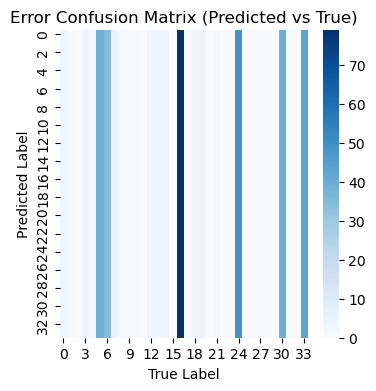

In [18]:
# Test if our metrics evaluation is working. Implement model that will only return 1 for any input and class

class DummyClassifier(GenrePredictorInterface):
    def predict(self, batch_features: dict) -> np.array:
        return np.ones_like(batch_features['labels'])
        
dummy_model = DummyClassifier()

metrics = evaluate_model(dummy_model, test_loader)

print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1-score:", metrics['f1'])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(metrics['error_matrix'], cmap="Blues")
plt.title("Error Confusion Matrix (Predicted vs True)")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show() 

## 1. Zero-shot learning

Let's write prompt that will be fed into model. We will do such in two manners. First, we can directly ask model to predict class of the song by using json format and then parsing it. Secondly, we can access to probability of '1' and '0'.

In [19]:
prompt_v1 = '''You are a music genre expert. You will determine whether a song belongs to a specific genre based on its lyrics. You will be provided with a JSON input containing the lyrics and the target genre. Respond with 1 if the song likely belongs to the specified genre, and 0 if it does not.

**Input format:**
```json
{
    "lyrics": "Lyrics of the song",
    "genre": "Target genre"
}
```

**Output format:**
```json
{
    "predict": 1  // if the song belongs to the genre
    // or
    "predict": 0  // if it does not
}
```

**Lyrics with genre for classification:**
```json
{
    "lyrics": "%s",
    "genre": "%s"
}
```

**Your output**:
'''

def parse_model_response(response: str) -> int:
    try:
        # Попробуем извлечь JSON через регулярку (на случай мусора вокруг)
        match = re.search(r'\{[^}]*"predict"\s*:\s*(0|1)[^}]*\}', response)
        if match:
            data = json.loads(match.group(0))
            return int(data['predict'])
    except Exception as e:
        print(f"Parsing error: {e}")

    raise ValueError("Could not parse prediction from model response.")


class ZeroShotClassifier(GenrePredictorInterface):
    def __init__(self, model, tokenizer, genres, prompt_template, device="cuda", max_lyrics_length=300):
        self.model = model
        self.tokenizer = tokenizer
        self.genres = genres  # список всех возможных жанров
        self.device = device
        self.max_lyrics_length = max_lyrics_length
        self.prompt_template = prompt_template
        
    def _make_prompts(self, lyrics: str) -> list[str]:
        truncated = lyrics[:self.max_lyrics_length].replace('\n', ' ').replace('"', "'")
        prompts = [self.prompt_template % (truncated, genre) for genre in self.genres]
        return prompts

    def _parse_response(self, response: str) -> int:
        try:
            match = re.search(r'\{[^}]*"predict"\s*:\s*(0|1)[^}]*\}', response)
            if match:
                data = json.loads(match.group(0))
                return int(data["predict"])
        except Exception as e:
            print(f"Parse error: {e}")
        return 0  # fallback to 0 if anything goes wrong
    

def make_prompts(lyrics: str) -> list[str]:
    truncated = lyrics[:300].replace('\n', ' ').replace('"', "'")
    prompts = [prompt_v1 % (truncated, genre) for genre in genres]
    return prompts

def parse_response(response: str) -> int:
    try:
        match = re.search(r'\{[^}]*"predict"\s*:\s*(0|1)[^}]*\}', response)
        if match:
            data = json.loads(match.group(0))
            return int(data["predict"])
    except Exception as e:
        print(f"Parse error: {e}")
    return 0  # fallback to 0 if anything goes wrong

In [20]:
# suppose we have lyrics and target genre
lyrics = val_dataset[0]['features']['lyrics']
target_genre = val_dataset[0]['features']['genre']
print(lyrics[:100])
print(target_genre)

# let's try ask model if that song is belongs to target genre
truncated = lyrics[:300]
instruct = prompt_v1 % (truncated, target_genre)

print(instruct)

# prepare the model input
messages = [
    {"role": "user", "content": instruct}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False,
    do_sample=False
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=32768
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

try:
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0
    
thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")
print("thinking content:", thinking_content)
print("content:", content)

[Chorus: Lil Noid] Try me, try me if you wanna try When I'm on the snow I feel like I can fly Try me
hip hop
You are a music genre expert. You will determine whether a song belongs to a specific genre based on its lyrics. You will be provided with a JSON input containing the lyrics and the target genre. Respond with 1 if the song likely belongs to the specified genre, and 0 if it does not.

**Input format:**
```json
{
    "lyrics": "Lyrics of the song",
    "genre": "Target genre"
}
```

**Output format:**
```json
{
    "predict": 1  // if the song belongs to the genre
    // or
    "predict": 0  // if it does not
}
```

**Lyrics with genre for classification:**
```json
{
    "lyrics": "[Chorus: Lil Noid] Try me, try me if you wanna try When I'm on the snow I feel like I can fly Try me, try me if you wanna try When I'm on the snow I feel like I can fly Try me, try me if you wanna try When I'm on the snow I feel like I can fly Try me, try me if you wanna try When I'm on the snow I f",
 

In [21]:
class ZeroShotClassifierV1(ZeroShotClassifier):
    def __init__(self, model, tokenizer, genres, prompt_template, device="cuda", max_lyrics_length=300, batch_size=2):
        """
        batch_size — размер мини-батча для генерации (не batch['features']).
        """
        super().__init__(model, tokenizer, genres, prompt_template, device, max_lyrics_length)
        self.batch_size = batch_size

    def predict(self, batch: dict, enable_thinking=False, debug: bool = False) -> np.ndarray:
        lyrics_list = [row['lyrics'] for row in batch['features']]
        all_prompts = []
        index_map = []

        for i, lyrics in enumerate(lyrics_list):
            truncated = lyrics[:self.max_lyrics_length]
            for genre in self.genres:
                prompt = self.prompt_template % (truncated, genre)
                all_prompts.append(prompt)
                index_map.append(i)

        if debug:
            logger.info(f"Total prompts: {len(all_prompts)}")
            logger.info(f"Example prompt:\n{all_prompts[0]}")

        # Шаблоны превращаются в текст через chat_template
        instruct_texts = [
            self.tokenizer.apply_chat_template(
                [{"role": "user", "content": prompt}],
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=enable_thinking,
                do_sample=False
            )
            for prompt in all_prompts
        ]

        # Подаём списками по batch_size
        generated_texts = []
        full_generated = []
        self.model.eval()

        for i in range(0, len(instruct_texts), self.batch_size):
            batch_texts = instruct_texts[i:i + self.batch_size]
            model_inputs = self.tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(self.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    **model_inputs,
                    max_new_tokens=1024,
                    pad_token_id=self.tokenizer.eos_token_id
                )

            for j in range(len(batch_texts)):
                output_ids = outputs[j][len(model_inputs["input_ids"][j]):].tolist()

                try:
                    split_idx = len(output_ids) - output_ids[::-1].index(151668)
                except ValueError:
                    split_idx = 0

                thinking_content = tokenizer.decode(output_ids[:split_idx], skip_special_tokens=True).strip("\n")
                main_output = self.tokenizer.decode(output_ids[split_idx:], skip_special_tokens=True).strip()
                
                full_generated.append(thinking_content + main_output)
                generated_texts.append(main_output)

        if debug:
            logger.info("Sample model outputs:\n" + "\n---\n".join(generated_texts[:3]))

        # Собираем финальные предсказания
        batch_size = len(lyrics_list)
        num_genres = len(self.genres)
        predictions = np.zeros((batch_size, num_genres), dtype=np.int32)

        for i, raw_output in enumerate(generated_texts):
            sample_idx = index_map[i]
            genre_idx = i % num_genres
            try:
                predictions[sample_idx, genre_idx] = self._parse_response(raw_output)
            except Exception as e:
                logger.warning(f"Failed to parse output: {raw_output}, error: {e}")

        if debug:
            for i, pred in enumerate(predictions):
                predicted_genres = [g for g, flag in zip(self.genres, pred) if flag]
                logger.info(f"Sample {i} predicted genres: {predicted_genres}")

        return predictions, full_generated, instruct_texts


In [22]:
def test_classifier(enable_thinking):
    classifier_v1 = ZeroShotClassifierV1(model, tokenizer, genres, prompt_v1, device=device, max_lyrics_length=250, batch_size=128)

    batch = next(iter(val_loader))
    batch['features'] = batch['features'][:1]
    ground_truth = batch['labels'][:1]

    predictions, generated_texts, instruct_texts = classifier_v1.predict(batch, enable_thinking=enable_thinking)
    print('Ground trith labels:', ground_truth)
    print('Predicted labels:', predictions)

    print("\nLet's take a look at specific instruct:")
    print(instruct_texts[10])
    print("\nAnd here is the answer:")
    print(generated_texts[10])
    print('\nActual genre was:', one_hot_encoded_to_genre_list(ground_truth[0]))
    print('\nPredicted genre is:', one_hot_encoded_to_genre_list(predictions[0]))

In [23]:
print('Test classifier with turned on thinking mode')
test_classifier(True)

print('\n\n\n\nTest classifier with turned off thinking mode')
test_classifier(False)

Test classifier with turned on thinking mode
Ground trith labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Predicted labels: [[0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1]]

Let's take a look at specific instruct:
<|im_start|>user
You are a music genre expert. You will determine whether a song belongs to a specific genre based on its lyrics. You will be provided with a JSON input containing the lyrics and the target genre. Respond with 1 if the song likely belongs to the specified genre, and 0 if it does not.

**Input format:**
```json
{
    "lyrics": "Lyrics of the song",
    "genre": "Target genre"
}
```

**Output format:**
```json
{
    "predict": 1  // if the song belongs to the genre
    // or
    "predict": 0  // if it does not
}
```

**Lyrics with genre for classification:**
```json
{
    "lyrics": "[Chorus: Lil Noid] Try me, try me if you wa